In [229]:
# ## 1️⃣ Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import ESN
import glob
import re

In [230]:
# Fixer la graine pour reproductibilité
rpy.set_seed(42)

In [231]:
# ## 2️⃣ Chargement des données (8 premières courses)
data_dir = "../projet_data/data"
files = glob.glob(f"{data_dir}/course*.csv")

def course_idx(path):
    m = re.search(r"course(\d+)\.csv", path)
    return int(m.group(1)) if m else 1e9

files = sorted(files, key=course_idx)
train_files = files[3:10]
print("Fichiers d'entraînement:", [f.split("/")[-1] for f in train_files])

X_train_list_raw = []
y_train_list_raw = []

for fp in train_files:
    df = pd.read_csv(fp, sep=';', decimal=',').fillna(0)
    df["Time"] = pd.to_datetime(df["Time"])
    df["t_elapsed"] = (df["Time"] - df["Time"].iloc[0]).dt.total_seconds()
    total_time = df["t_elapsed"].iloc[-1]
    df["time_remaining"] = total_time - df["t_elapsed"]
    km_total = df["km"].iloc[-1]
    df["km_total"] = km_total

    Xi = df[["km", "speed_kmh", "FC", "km_total"]].values
    yi = df["time_remaining"].values.reshape(-1, 1)

    delta_t = 30  # nombre de pas dans le futur

    X_train_list_raw.append(Xi[:-delta_t])
    y_train_list_raw.append(Xi[delta_t:, 1].reshape(-1, 1))

print("Nombre de courses entraînement:", len(X_train_list_raw))

Fichiers d'entraînement: ['data\\course4.csv', 'data\\course5.csv', 'data\\course6.csv', 'data\\course7.csv', 'data\\course8.csv', 'data\\course9.csv', 'data\\course10.csv']
Nombre de courses entraînement: 7


In [232]:
# ## 3️⃣ Normalisation simple (0-1) sur l'ensemble d'entraînement
X_concat = np.vstack(X_train_list_raw)
y_concat = np.vstack(y_train_list_raw)

X_max = X_concat.max(axis=0)
y_max = y_concat.max()

Xn_train_list = [Xi / X_max for Xi in X_train_list_raw]
Yn_train_list = [yi / y_max for yi in y_train_list_raw]

In [233]:
# ## 4️⃣ Création du réservoir
reservoir = Reservoir(units=100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)
esn_model = reservoir >> readout


In [234]:
# ## 5️⃣ Entraînement sur listes de séquences
warmup = 20
esn_model = esn_model.fit(Xn_train_list, Yn_train_list, warmup=warmup)

print("Reservoir initialized:", reservoir.initialized)
print("Readout initialized:", readout.initialized)

Reservoir initialized: True
Readout initialized: True


In [235]:
# ## 6️⃣ Prédiction sur une course de test (non vue)
# Utilise la 9e course si disponible, sinon la dernière des 8 pour démonstration.
test_file = files[1] if len(files) > 8 else train_files[-1]
print("Fichier de test:", test_file.split("/")[-1])

test_df = pd.read_csv(test_file, sep=';', decimal=',').fillna(0)
test_df["Time"] = pd.to_datetime(test_df["Time"])
test_df["t_elapsed"] = (test_df["Time"] - test_df["Time"].iloc[0]).dt.total_seconds()
total_time_test = test_df["t_elapsed"].iloc[-1]
test_df["time_remaining"] = total_time_test - test_df["t_elapsed"]
km_total_test = test_df["km"].iloc[-1]
test_df["km_total"] = km_total_test

X_test_raw = test_df[["km", "speed_kmh", "FC", "km_total"]].values

X_test_n = X_test_raw / X_max

esn_model.reset()
y_pred_n = esn_model.run(X_test_n[:-delta_t])
y_pred = y_pred_n * y_max
y_real = X_test_raw[delta_t:, 1].reshape(-1,1)
print("Shapes pred/real:", len(y_pred), len(y_real))

Fichier de test: data\course2.csv
Shapes pred/real: 7717 7717


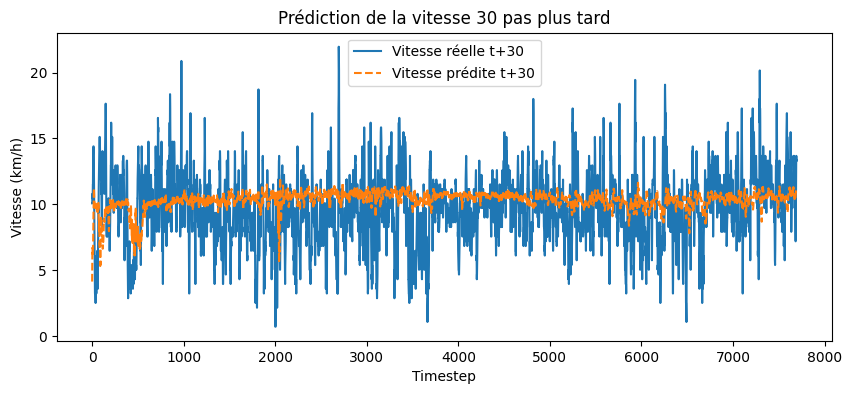

In [236]:
# ## 7️⃣ Visualisation
start = warmup
end = min(len(y_pred), len(y_real))

plt.figure(figsize=(10,4))
plt.plot(y_real[start:end], label=f"Vitesse réelle t+{delta_t}")
plt.plot(y_pred[start:end], "--", label=f"Vitesse prédite t+{delta_t}")
plt.xlabel("Timestep")
plt.ylabel("Vitesse (km/h)")
plt.title(f"Prédiction de la vitesse {delta_t} pas plus tard")
plt.legend()
plt.show()

In [237]:
diff = y_pred - X_test_raw[:-delta_t, 1].reshape(-1,1)
direction = np.where(diff > 0, "↑", "↓")  # ↑ = augmentation, ↓ = baisse

# Exemple
t = 1256
t = min(t, len(direction)-1)
print(f"t={t} : v_actuelle={X_test_raw[t,1]:.1f} km/h, v_prévue(t+{delta_t})={y_pred[t,0]:.1f} km/h, direction prédite = {direction[t]}")

t=1256 : v_actuelle=9.4 km/h, v_prévue(t+30)=9.9 km/h, direction prédite = ['↑']
